In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 70)
pd.set_option('display.max_columns', 50)

In [2]:
df = pd.read_csv('../data/EK_trimmed.csv')
df.loc[:, 'TRAIN_SERVICE_CODE_AFFECTED'] = df['TRAIN_SERVICE_CODE_AFFECTED'].astype(str)
df.loc[:, 'UNIT_CLASS_AFFECTED'] = df['UNIT_CLASS_AFFECTED'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482600 entries, 0 to 482599
Data columns (total 13 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   EVENT_DATETIME                482600 non-null  object 
 1   TRAIN_SERVICE_CODE_AFFECTED   482600 non-null  object 
 2   ENGLISH_DAY_TYPE              482600 non-null  object 
 3   APP_TIMETABLE_FLAG_AFF        482600 non-null  object 
 4   TRAIN_SCHEDULE_TYPE_AFFECTED  482600 non-null  object 
 5   TRACTION_TYPE_AFFECTED        482600 non-null  object 
 6   UNIT_CLASS_AFFECTED           482600 non-null  object 
 7   INCIDENT_REASON               482600 non-null  object 
 8   Lat_OR                        482600 non-null  float64
 9   Lon_OR                        482600 non-null  float64
 10  Lat_DES                       482600 non-null  float64
 11  Lon_DES                       482600 non-null  float64
 12  PFPI_MINUTES                  482600 non-nul

In [3]:
df.loc[:, 'EVENT_DATETIME'] = pd.to_datetime(df.EVENT_DATETIME)
df.loc[:, 'MONTH'] = df.EVENT_DATETIME.dt.month
df.loc[:, 'DAY'] = df.EVENT_DATETIME.dt.day
df.loc[:, 'HOUR'] = df.EVENT_DATETIME.dt.hour
df.loc[:, 'MINUTE'] = df.EVENT_DATETIME.dt.minute
df.drop(columns='EVENT_DATETIME', inplace = True)

In [4]:
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import set_config; set_config(display='diagram')


In [5]:
num_transformer = MinMaxScaler()

cat_transformer = OneHotEncoder(handle_unknown='ignore', drop='if_binary')

from sklearn.preprocessing import FunctionTransformer


def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['Lat_OR', 'Lon_OR', 'Lat_DES', 'Lon_DES']),
    ('cat_transformer', cat_transformer, ['TRAIN_SERVICE_CODE_AFFECTED', 'ENGLISH_DAY_TYPE', 'APP_TIMETABLE_FLAG_AFF', 'TRAIN_SCHEDULE_TYPE_AFFECTED', 'TRACTION_TYPE_AFFECTED', 'UNIT_CLASS_AFFECTED', 'INCIDENT_REASON' ]),
    ('month_sin', sin_transformer(12), ['MONTH']),
    ('month_cos', cos_transformer(12), ['MONTH']),
    ('day_sin', sin_transformer(12), ['DAY']),
    ('day_cos', cos_transformer(12), ['DAY']),
    ('hour_sin', sin_transformer(12), ['HOUR']),
    ('hour_cos', cos_transformer(12), ['HOUR']),
    ('minute_sin', sin_transformer(12), ['MINUTE']),
    ('minute_cos', cos_transformer(12), ['MINUTE'])
], sparse_threshold=0)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='PFPI_MINUTES'), np.log(df['PFPI_MINUTES']), test_size=0.3)

In [7]:
print(X_train.shape)
print(X_test.shape)

(337820, 15)
(144780, 15)


In [8]:
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

(array([255.,  72.,  30.,  20.,  13.,  12.,  17.,  30.,  28.,   2.]),
 array([ 61. ,  82.4, 103.8, 125.2, 146.6, 168. , 189.4, 210.8, 232.2,
        253.6, 275. ]),
 <BarContainer object of 10 artists>)

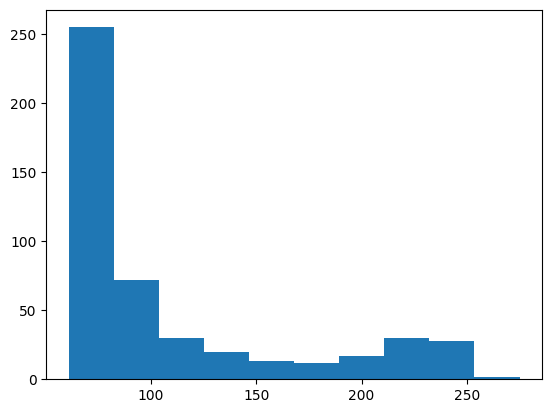

In [12]:
import matplotlib.pyplot as plt
plt.hist(df[df['PFPI_MINUTES']>60]['PFPI_MINUTES'])

In [10]:
# Create your new scorer to minimize
from sklearn.metrics import make_scorer

from sklearn.metrics import mean_squared_error
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)

# Create your new scorer to maximize
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

model_lin = LinearRegression()

cross_val_score(model_lin, X_train_scaled, y_train, cv=10, scoring=rmse).mean()

0.6655966806331571

In [12]:
from xgboost import XGBRegressor
import xgboost
xgboost.config_context(verbosity = 2)

In [13]:
model_xgb = XGBRegressor(max_depth=10, n_estimators=500, learning_rate=0.01, n_jobs = -1)

In [14]:
cross_val_score(model_xgb, X_train_scaled, y_train, cv=10, scoring=rmse).mean()

0.5331671574595769

In [15]:
model_lin.fit(X_train_scaled, y_train)
model_lin.score(X_test_scaled, y_test)

0.2740068163761622

In [16]:
np.exp(y_test)

367621     4.0
280695     3.0
324422     1.0
2318       6.0
51761      2.0
          ... 
273490     3.0
112556     3.0
35185      2.0
244545    11.0
209350     5.0
Name: PFPI_MINUTES, Length: 144780, dtype: float64

In [17]:
np.exp(model_lin.predict(X_test_scaled))

array([3.46064531, 1.30456433, 2.19167911, ..., 2.80799499, 1.61485965,
       2.02301676])

In [18]:
np.abs(np.exp(y_test) - np.exp(model_lin.predict(X_test_scaled)))

367621    0.539355
280695    1.695436
324422    1.191679
2318      1.171852
51761     1.318334
            ...   
273490    0.296939
112556    0.495190
35185     0.807995
244545    9.385140
209350    2.976983
Name: PFPI_MINUTES, Length: 144780, dtype: float64

In [19]:
from sklearn.metrics import r2_score

r2_score(np.exp(y_test), np.exp(model_lin.predict(X_test_scaled)))

0.03267865143441473